## Data Loading and Initial Inspection

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

file_path = os.path.join('..','data', 'Olympic_Swimming.csv')

# Check if the file exists
if not os.path.exists(file_path):
    print(f"Error: Data file not found at {file_path}")
else:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")

# Display basic information
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

Data loaded successfully!

First 5 rows:
  Location  Year Distance (in meters)      Stroke  Relay? Gender Team  \
0    Tokyo  2020                 100m  Backstroke       0    Men  ROC   
1    Tokyo  2020                 100m  Backstroke       0    Men  ROC   
2    Tokyo  2020                 100m  Backstroke       0    Men  USA   
3    Tokyo  2020                 100m  Backstroke       0    Men  ITA   
4    Tokyo  2020                 100m  Backstroke       0    Men  CHN   

              Athlete Results  Rank  
0        Evgeny Rylov   51.98     1  
1  Kliment Kolesnikov      52     2  
2         Ryan Murphy   52.19     3  
3       Thomas Ceccon    52.3     4  
4            Jiayu Xu   52.51     4  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Location              4359 non-null   object
 1   Year           

## Data Cleaning and Handling Missing Values.

In [12]:
print(df.isnull().sum())

Location                 0
Year                     0
Distance (in meters)     0
Stroke                   0
Relay?                   0
Gender                   0
Team                     0
Athlete                 14
Results                 28
Rank                     0
dtype: int64


In [13]:
# Drop rows where 'Athlete' or 'Results' are missing
# We drop these because athlete name is a key identifier and missing results are hard to impute meaningfully for prediction
initial_rows = len(df)
df.dropna(subset=['Athlete', 'Results'], inplace=True)
rows_after_dropping = len(df)

print(f"\nDropped rows with missing 'Athlete' or 'Results'.")
print(f"Initial rows: {initial_rows}")
print(f"Rows after dropping: {rows_after_dropping}")
print(f"Number of rows dropped: {initial_rows - rows_after_dropping}")

# Verify missing values again
print("\nMissing values per column after dropping:")
print(df.isnull().sum())


Dropped rows with missing 'Athlete' or 'Results'.
Initial rows: 4359
Rows after dropping: 4317
Number of rows dropped: 42

Missing values per column after dropping:
Location                0
Year                    0
Distance (in meters)    0
Stroke                  0
Relay?                  0
Gender                  0
Team                    0
Athlete                 0
Results                 0
Rank                    0
dtype: int64


convert results colunms to seconds

### Total Medals Awarded Per Year

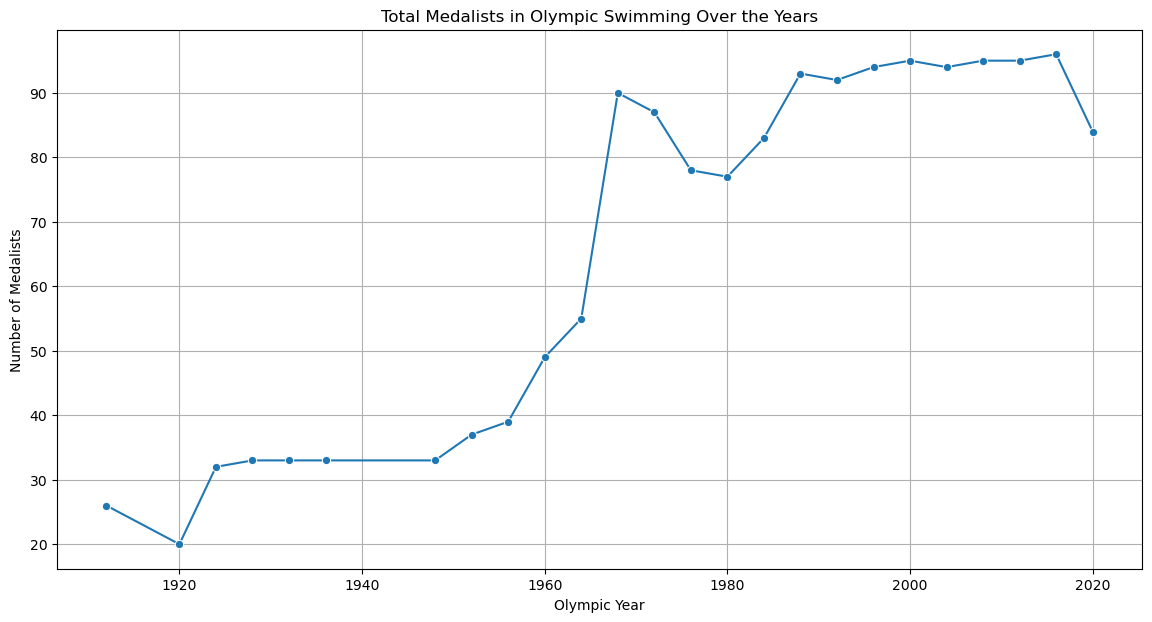

In [16]:
# Count total medalists per year (Ranks 1, 2, 3)
medalists_per_year = df[df['Rank'].isin([1, 2, 3])]['Year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x=medalists_per_year.index, y=medalists_per_year.values, marker='o')
plt.title('Total Medalists in Olympic Swimming Over the Years')
plt.xlabel('Olympic Year')
plt.ylabel('Number of Medalists')
plt.grid(True)
plt.show()

add explination

### Gold Medal Times: 100m Freestyle (Men vs. Women) Over the Years